In [1]:
import qiskit

/home/hm-tlacherm/.local/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,


In [2]:
provider = qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
from collections import OrderedDict

from qiskit import Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
#from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

from qiskit.opflow import X, Y, Z, I, CX, T, H, S, PrimitiveOp, StateFn
from qiskit.providers.aer import noise

# Import error mitigation functions
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

import networkx as nx
import numpy as np
import pylab

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer,  CplexOptimizer, CobylaOptimizer, ADMMOptimizer,GroverOptimizer
#from qiskit_optimization.applications import Maxcut

from qiskit import BasicAer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import SPSA, COBYLA, ADAM, AQGD, NELDER_MEAD

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator

from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

import math

/home/hm-tlacherm/.local/lib/python3.6/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/hm-tlacherm/.local/lib/python3.6/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [4]:
from graph_helper import *
from QiskitMaxcut import *

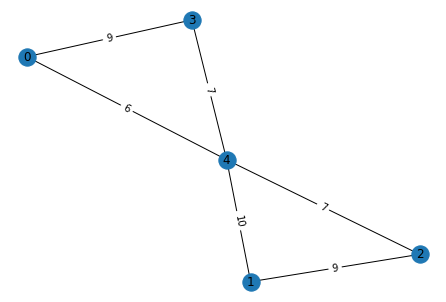

In [5]:
graph = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(graph)
max_cut_problem = max_cut.to_quadratic_program()
conv_toQubo = QuadraticProgramToQubo()
max_cut_qubo = conv_toQubo.convert(max_cut_problem)
max_cut.draw()

In [6]:
MAX_ITER = 100
optimizers = {
    #"ADAM": ADAM(maxiter=MAX_ITER), # benötigt extrem lange 
    #"AQGD": AQGD(maxiter=MAX_ITER), # benötigt extrem lange 
    "SPSA": SPSA(maxiter=MAX_ITER),
    "COBYLA": COBYLA(maxiter=MAX_ITER),
    #"NELDER_MEAD": NELDER_MEAD(maxiter=MAX_ITER),
}
REPS_MAX = 10
REPS_MIN = 1
GAMMA_MIN = -math.pi
GAMMA_MAX = math.pi
BETA_MIN = -math.pi
BETA_MAX = math.pi
N_TRIALS = 10

# Noise 
BACKEND_NAME = 'ibmq_montreal'
noise_backend = provider.get_backend(BACKEND_NAME)
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [7]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=Aer.get_backend('qasm_simulator'), 
                    shots=8000,
                    noise_model=noise_model,
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    measurement_error_mitigation_cls=CompleteMeasFitter,
                    measurement_error_mitigation_shots=8000
    )
    
    qaoa = QAOA(optimizer=optimizer, quantum_instance=quantum_instance, reps=reps, 
               initial_point=init_parameters) 
    # currently only works with Qiskit v 0.27
    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True,
                                 qaoa=qaoa)
    
    return ws_qaoa

In [8]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    #algorithm = MinimumEigenOptimizer(qaoa)
    result = qaoa.solve(max_cut_problem)
    optimal_parameters = qaoa._qaoa.optimal_params
    
    return result, optimal_parameters.copy() 

In [9]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]
        
    qaoa = init_qaoa(optimizer, reps, parameters)
    
    result, optimal_parameters = run(max_cut_problem, qaoa)
    print(result)
    mean, distribution = max_cut.analyse(result)
    
    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters])   
    
    return -mean

In [10]:
def save_best_trial(study, trial):
    if study.best_trial.number == trial.number:
        mean, result, optimal_parameters = trial.user_attrs["best"]
        result_copy = OptimizationResult(result.x.copy(), result.fval.copy(), result.variables.copy(), status=result.status, samples=result.samples.copy())  
        study.set_user_attr(key="best", value=[mean,result_copy, optimal_parameters.copy()])


In [12]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-21 17:17:25,039] A new study created in memory with name: no-name-e03a1978-b3f5-4de3-b6b0-dd09b4cb5702
[W 2021-07-21 17:17:25,123] Trial 0 failed because of the following error: ValueError('The dimension of the initial point (14) does not match the number of parameters in the circuit (8).',)
Traceback (most recent call last):
  File "/home/hm-tlacherm/.local/lib/python3.6/site-packages/optuna/_optimize.py", line 216, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-9-3cb3805f7ad6>", line 15, in objective
    result, optimal_parameters = run(max_cut_problem, qaoa)
  File "<ipython-input-8-a140bec1e179>", line 4, in run
    result = qaoa.solve(max_cut_problem)
  File "/home/hm-tlacherm/.local/lib/python3.6/site-packages/qiskit_optimization/algorithms/warm_start_qaoa_optimizer.py", line 332, in solve
    results.append(self._solve_internal(operator, offset, converted_problem, problem))
  File "/home/hm-tlacherm/.local/lib/python3.6/site-packages/qiskit_opt

ValueError: The dimension of the initial point (14) does not match the number of parameters in the circuit (8).

In [ ]:
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params = study.user_attrs["best"]
optimal_params

In [ ]:
max_cut.draw(result)

In [ ]:
mean, distribution = max_cut.analyse(result, print_output=True)
plot_histogram(distribution, color='midnightblue', title=f"Expectation Value (Ø: {mean:.3f})")

In [30]:
import qiskit.tools.jupyter
%qiskit_version_table